In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import dit
import admUI
import math

# Introduction

This tutorial shows an application of the BROJA information decomposition on the **[US Census 1994][us-census]** income data set. The task is to relate a list of attributes or predictors with a binary target variable. The attributes include: sex, age, race, education level, occupation, hours-per-week, etc. The target is the yearly income, with values $>50$K and $\leq50$K. 


This tutorial is written by [Pattarawat Chormai](https://pat.chormai.org) and licensed under [CC-BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/).

[us-census]: https://archive.ics.uci.edu/ml/datasets/adult

# Data Preparation

In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

In [3]:
column_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "martital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]


df = pd.read_csv(data_url, names=column_names)

## Cleansing

In [4]:
# data exploration

df[:5]

,age,workclass,fnlwgt,education,education-num,martital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
df[:1].values

array([[39, ' State-gov', 77516, ' Bachelors', 13, ' Never-married',
        ' Adm-clerical', ' Not-in-family', ' White', ' Male', 2174, 0,
        40, ' United-States', ' <=50K']], dtype=object)

As you can see from the above, some attributes (columns) contains a space in the beginning. Although these spaces do not
affect our computation, it is still good to clean it up.

In [6]:
for k, v in zip(column_names, df.dtypes):
    if v == "object":
        df[k] = df[k].apply(lambda x: x.strip())

## Discretization

Some attributes such as age and hours-per-week are continuous. We discretize these attributes as follows: 

- We categorize `age` into four groups: [ '<24', '24-35', '36-50', '>50' ], and
- We group `hours_per_week_group` into two groups: ['<=40', '>40']

In [7]:
age_groups = ['<24', '24-35', '36-50', '>50']
df['age-group'] = df.age.apply(lambda x: age_groups[np.digitize(x, [24, 36, 51])])

hours_per_week_group = ['<=40', '>40']
df['hours-per-week-group'] = df['hours-per-week'].apply(lambda x: hours_per_week_group[0 if x <= 40 else 1])

## Distribution

The code expects a joint distribution over predictors and target to be passed in dit format.

In [8]:
# select only columns that we will use in this tutorial
selected_columns = [
    'income',
    'education',
    'sex',
    'race',
    'occupation',
    'age-group',
    'hours-per-week-group'
]

# aliases
rvs_names = [
    'X',  # income
    'E',  # education
    'G',  # sex
    'R',  # race
    'O',  # occupation
    'A',  # age
    'H',  # hours-per-week
]

rvs_to_name = dict(zip(rvs_names, selected_columns))

In [9]:
# take all samples with attributes that we're interested in 
data_array = list(map(lambda r: tuple(r[k] for k in selected_columns), df.to_dict("record")))

# create distribution from the samples with uniform distribution
dist_census = dit.Distribution(data_array, [1. / df.shape[0] ] * df.shape[0])

# set variable aliases to the discribution
dist_census.set_rv_names("".join(rvs_names))

In [10]:
# marginal distribution of P(G), G is `sex`
dist_census.marginal('G')

Class:,Distribution
Alphabet:,"('Female', 'Male') for all rvs"
Base:,linear
Outcome Class:,tuple
Outcome Lenght:,1
G,p(x)
Female,0.33079450876815825
Male,0.6692054912318418


In [11]:
# conditional probablity P(S|G).
marginal, cdists = dist_census.condition_on('G', rvs='X')

for i, (c, d) in enumerate(zip(cdists, marginal.zipped())):
    print("")
    print("-----------------------")
    print("Marginal: %s | %f" % d)
    print("P(S|H='%s')" % (d[0]))
    print(c)


-----------------------
Marginal: ('Female',) | 0.330795
P(S|H='Female')
Class:          Distribution
Alphabet:       ('<=50K', '>50K') for all rvs
Base:           linear
Outcome Class:  tuple
Outcome Length: 1
RV Names:       ('X',)

x            p(x)
('<=50K',)   0.8905394113824158
('>50K',)    0.10946058861758425

-----------------------
Marginal: ('Male',) | 0.669205
P(S|H='Male')
Class:          Distribution
Alphabet:       ('<=50K', '>50K') for all rvs
Base:           linear
Outcome Class:  tuple
Outcome Length: 1
RV Names:       ('X',)

x            p(x)
('<=50K',)   0.6942634235888022
('>50K',)    0.3057365764111978


# Basic Information Theory

We review some basic definitions from information theory. 


## Entropy
Let $X$ be a discreate random variable.  Random variable $X$ takes values from $\mathcal{X}$ and has probability mass function $p(x) = P\{X=x\}, x \in \mathcal{X} $.

**Definition:** Entropy $H(X)$ of a discrete random variable $X$  is defined as

$$
H(X) = - \sum_{x \in \mathcal{X} } p(x) \log_{2} p(x).
$$

In [12]:
# H(G)
p_G = dist_census.marginal('G')
dit.shannon.entropy(p_G)

0.9157360598501509

### Joint Entropy and Contional Entropy

Let $(X, Y)$ be a pair of discrete random variable with a joint distribution $p(x,y)$, $x \in \mathcal{X}$ and $y \in \mathcal{Y}$.

**Definition:** Joint Entropy $H(X,Y)$ is definied as

$$
H(X, Y) = - \sum_{x \in \mathcal{X}} \sum_{y \in \mathcal{Y}} p(x, y) \log p(x, y).
$$

In [13]:
# H(X, G)
p_XG = dist_census.marginal('XG')
dit.shannon.entropy(p_XG)

1.674948627614043

**Definition:** Conditional Entropy $H(Y|X)$ is defined as 

$$
H(Y|X) = - \sum_{x \in \mathcal{X}} \sum_{y \in \mathcal{Y}} p(x, y) \log p(y|x).
$$

In [14]:
# H(X|G)
dit.shannon.conditional_entropy(dist_census, 'X', 'G') 

0.7592125677638922

In [15]:
dit.shannon.entropy(p_XG) \
    == dit.shannon.entropy(p_G) + dit.shannon.conditional_entropy(dist_census, 'X', 'G') 

True

## Relative Entropy

Let $p$ and $q$ be two distributions with probability mass function $p(x)$ and $q(x)$ accordingly. Relative entropy is a distance between $p$ and $q$.

**Definition:** Relative entropy between two distributions $p$ and $q$ $D(p\|q)$ is defined as 

$$
D(p\|q) = \sum_{x \in \mathcal{X}} p(x) \log \frac{p(x)}{q(x)}.
$$

Another name of relative entropy is **Kullback-Leibler** divergence. Important properties of $D(p\|q)$ are:
- $D(p\|q) \neq D(q\|p)$
- $D(p\|q) = 0$ iff.  $p=q$ 
- $D(p\|q) = \infty $ if there is some $x \in \mathcal{X}$ that $p(x) > 0$ and $q(x) = 0$.

## Mutual Information

For two discrete random variables $X$ and $Y$ with a joint probability $p(x, y)$ and marginal probablity mass function $p(x)$ and $p(y)$. 


**Definition:** Mutual information $I(X; Y)$ is the relative entropy between $p(x, y)$ and $p(x)p(y)$: 

$$
\begin{align*}
I(X; Y) &= D \big(p(x, y) \| p(x)p(y) \big) \\
&= \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}} p(x, y) \log \frac{p(x, y)}{p(x)p(y)} \\
&= \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}} p(x, y) \big( \log p(x, y) -  \log p(x) - \log p(y) \big) \\
&= - H(X, Y) - \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}} p(x, y) \log p(x) - \sum_{x \mathcal{X}}\sum_{y \in \mathcal{Y}} p(x, y) \log p(y) \\
&= H(X) + H(Y) - H(X, Y).
\end{align*}
$$

In [16]:
dit.shannon.mutual_information(dist_census, 'X', 'G')

0.037171387438320824

### Contitional Mutual Information

**Definition:** For three discrete random variables $X, Y, Z$, the conditional mutual information $I(X; Y |Z)$ is defined as

$$
I(X; Y |Z) = H(X|Z) - H(X|Y,Z).
$$

In [17]:
# I(X, H | O)
dit.shannon.conditional_entropy(dist_census, 'X', 'O') - \
 dit.shannon.conditional_entropy(dist_census, 'X', 'HO')

0.02187436337675841

# Information Decomposition

Suppose that we have three jointly distributed random variables, $X, Y, Z$. Suppose that we are interested in knowing $X$, but we can only observe $Y$ and / or $Z$.


![](https://i.imgur.com/GpHQ6MW.png)



[Bertschinger et al. (2014)][paper] proposes one approach to decompose $I(X; (Y, Z))$ into four quantities:


![](https://i.imgur.com/c3tEced.png)

$$
I(X; Y, Z) = SI(X; Y, Z) + CI(X; Y, Z) + UI(X; Y \backslash Z) + UI(X; Z \backslash Y),
$$

where 
- $SI(X; Y, Z)$ is shared information that both $Y$ and $Z$ have about $X$,
- $CI(X; Y, Z)$ is complimentary (synergic) information that $Y$ and $Z$ have about $X$ when considering them together,
- $UI(X; Y \backslash Z)$ is unique information that only $Y$ has about $X$ (in respect to $Z$), and vice versa. 


## Shared Information
Furthermore, we have the following equilities:

$$
\begin{align*}
 SI(X; Y, Z) = I(X; Y) -  UI(X; Y \backslash Z) = I(X; Z) - UI(X; Z \backslash Y) \\
\end{align*}
$$


[paper]: https://www.mdpi.com/1099-4300/16/4/2161

## Co-Information

**Definition:** The coinformation is defined as [(McGill W. (1994)][mcgill]

$$
\begin{align*}
CoI(X;Y;Z) &= I(X;Y) - I(X;Y|Z) \\
&= SI(X; Y, Z) - CI(X; Y, Z)
\end{align*}
.
$$


[mcgill]: https://ieeexplore.ieee.org/abstract/document/1057469


In [18]:
# compute CoI(X; E; G) using dit
dit.multivariate.coinformation(dist_census, 'XEG')

-0.00010688124181967851

In [19]:
# compute CoI(X; H; G) using dit
dit.multivariate.coinformation(dist_census, 'XHG')

0.012185581661140699

## Unique Information

To compute the information decomposition, it suffices to specify either a measure for $SI$, for $CI$ or for $UI$.
Bertschinger et al. (2014) define the unique information as follows:

$$
UI(X; Y \backslash Z) = \min_{Q \in \Delta_p} I_Q(X; Y|Z), 
$$

where $\Delta_p$ is a set of joint probability distributions that have the same marginal probablity distributions on $(X, Y)$ and $(X, Z)$ as $P \in \mathbb{P}_{ \mathcal{X} \times \mathcal{Y} \times \mathcal{Z} }$.

Formally, $\Delta_p$ is

$$
\Delta_p = \{ Q \in \mathbb{P}_{ \mathcal{X} \times \mathcal{Y} \times \mathcal{Z} }:  Q(X, Y) = P(X, Y) \text{ and } Q(X, Z) = P(X, Z) \}
$$

In [20]:
# find q for X, G, R (income, race, gender)
q_XGR = admUI.computeQUI(distSXY = dist_census.marginal('XGR'))

# due to the fact that computeQUI rename variables to SXY
# we need to rename them back to XGR
q_XGR.set_rv_names("XGR")

In [21]:
q_XGR

In [22]:
# H(X|G,R)
h_XgGR =  dit.shannon.conditional_entropy(q_XGR, 'X', 'GR')

# UI(X; G \ R) = I_Q { X; G \ R }
ui_XG_R = dit.shannon.conditional_entropy(q_XGR, 'X', 'R') - h_XgGR

ui_XG_R

0.028813064495489815

In [23]:
# UI(X; R \ G) = I_Q { X; R \ G }
ui_XR_G = dit.shannon.conditional_entropy(q_XGR, 'X', 'G') - h_XgGR

ui_XR_G 

1.9623869407237038e-05

In [24]:
# compute shared information
si_XGR = dit.shannon.mutual_information(q_XGR, 'X', 'G') - ui_XG_R 
si_XRG = dit.shannon.mutual_information(q_XGR, 'X', 'R') - ui_XR_G

# sanity check: by the definition of shared information
si_XGR == si_XRG

True

In [25]:
# by the definition of co-information
ci_XGR = si_XRG - dit.multivariate.coinformation(q_XGR, 'XGR')
ci_XGR

0.0

In [26]:
# sanity check: by the definition of Bertschinger et al. (2014)'s information decomposition
dit.shannon.mutual_information(q_XGR, 'X', 'GR') == ui_XG_R + ui_XR_G + si_XRG + ci_XGR 

True

# The information decomposition for the US census dataset

In [27]:
# define measurement metrics
metric_keys = ['si', 'ci', 'ui_0', 'ui_1']

# define legend labels
latex_labels = [
    '$SI$',
    '$CI$',
    '$UI(X; Y \\backslash Z)$',
    '$UI(X; Z \\backslash Y)$'
]

# define colour for ploting
colors = [
    '#27AB93',
    '#FF5716',
    '#D33139',
    '#522F60',
] 

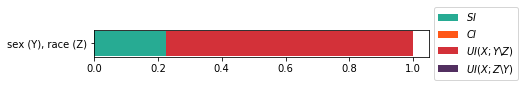

In [28]:
"""
define a auxiliary function which takes an array of

    {
        "variables": ["variable_0", "variable_1"],
        "metrics": {
            "mi": ...,
            "si": ..., 
            "ci": ...,
            "ui_0": ...,
            "ui_1": ...
        }
    },

"""


def plot(data):
    
    # definte the size of figure
    plt.figure(figsize=(6, 0.5*len(data)))
    
    labels = []
    metrics = []
    
    # suffix each variable name with an alias {Y, Z}
    for v in data:
        labels.append(", ".join(map(lambda p: "%s (%s)" % p, zip(v['variables'], ['Y', 'Z']))))
    
    for m in metric_keys:
        mm = []
        # extract corresponding metric from elements in array
        for v in data:
            mm.append(v['metrics'][m]/v['metrics']['mi'])
        metrics.append(mm)
    

    left = np.array([0]*len(labels))
    
    # plotting
    for i, kk in enumerate(metric_keys):
        plt.barh(
            labels, metrics[i], align='center', height=.5, left=left, label=latex_labels[i],color=colors[i],
        )
        left = left + metrics[i]
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plot([
    {
        "variables": ["sex", "race"],
        "metrics": {
            "mi": dit.shannon.mutual_information(q_XGR, 'X', 'RG'),
            "si": si_XGR, 
            "ci": ci_XGR,
            "ui_0": ui_XG_R,
            "ui_1": ui_XR_G,
        }
    },
])

We see that race (Z) conveys no unique information about income (X) w.r.t sex (Y). 

## Other variable pairs

In the following, we are going to compute the information decomposition between `income` and several pairs of variables, namely

- education and sex
- education and race
- race and occupation
- age-group and sex
- hours-per-week-group and occupation.

In [29]:
def information_decomposition(dist, src, to=""):
    rvs = src+to
    
    P = dist.marginal(rvs)
    
    variables = P._rvs
    
    q_SXY = admUI.computeQUI(distSXY = P)
    
    h_SgXY =  dit.shannon.conditional_entropy(q_SXY, 'S', 'XY')
    
    ui_SX_Y = dit.shannon.conditional_entropy(q_SXY, 'S', 'Y') - h_SgXY
    ui_SY_X = dit.shannon.conditional_entropy(q_SXY, 'S', 'X') - h_SgXY

    si_SXY_1 = dit.shannon.mutual_information(q_SXY, 'S', 'X') - ui_SX_Y
    si_SXY_2 = dit.shannon.mutual_information(q_SXY, 'S', 'Y') - ui_SY_X
    
    # sanity check
    assert math.isclose(si_SXY_1, si_SXY_2, abs_tol=1e-6), "SI_S_XY: %f | %f" % (si_SXY_1, si_SXY_2)

    si_SXY = si_SXY_1
    
    ci_SXY = si_SXY - dit.multivariate.coinformation(P, rvs)
    i_S_XY = dit.shannon.mutual_information(P, 'X', to)       

    # sanity check
    assert math.isclose(i_S_XY, si_SXY + ci_SXY + ui_SX_Y + ui_SY_X, abs_tol=1e-6), \
        "MI = decompose : %f | %f" % (i_S_XY, si_SXY + ci_SXY + ui_SX_Y + ui_SY_X)
    
    uis = [ui_SX_Y, ui_SY_X]
    return {
        "variables": tuple(map(lambda x: rvs_to_name[x], to)),
        "metrics": {
            "mi": i_S_XY,
            "si": si_SXY, 
            "ci": ci_SXY,
            "ui_0": uis[variables[to[0]]-1] ,
            "ui_1": uis[variables[to[1]]-1]
        }
    }

decomp_X_HO = information_decomposition(dist_census, 'X', 'HO')

In [30]:
decomp_X_EG = information_decomposition(dist_census, 'X', 'EG')

In [31]:
decomp_X_ER = information_decomposition(dist_census, 'X', 'ER')

In [32]:
decomp_X_RO = information_decomposition(dist_census, 'X', 'RO')

In [33]:
decomp_X_AG = information_decomposition(dist_census, 'X', 'AG')

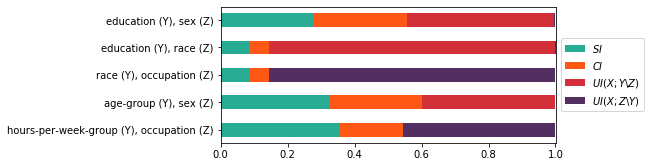

In [34]:
plot([
    decomp_X_EG,
    decomp_X_ER,
    decomp_X_RO,
    decomp_X_AG,
    decomp_X_HO,
][::-1])

We see that most of the information that race ($Y$) and occupation ($Z$) convey about income ($X$), is uniquely in the occupation. A more classical approach would be, of course, to test for the Markov relation $X-Z-Y$. This Markov relation almost holds, in the sense that $I(X;Y|Z)$ is small. The additional insight, due to the information decomposition, is that $I(X;Y|Z)$ is purely synergistic since there is no unique information that race conveys about income w.r.t. occupation. The phenomenon is even stronger for the pair (age, sex): The conditional mutual information is (relatively) larger, but still there is no unique information that sex conveys about income w.r.t. age. Education and sex have about equally large shared and synergistic components. Occupation conveys a large unique information about income both w.r.t. hours-per-week and education.

These observations appear quite reasonable. They illustrate how the decomposition allows us to obtain a fine-grained quantitative analysis of the relationships between the predictors and the target. 